In [29]:
import torch
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.env_checker import check_env
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from dynamic_tasker.access import *
from dynamic_tasker.schedulers import *
from dynamic_tasker.orbits import *
from dynamic_tasker.cameras import *
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, SubprocVecEnv
from gymnasium.wrappers import RecordEpisodeStatistics 
import scipy.stats as st
import datetime
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
class LookaheadEnv(gym.Env):

    def __init__(self, orbit, requests, t_start, t_end, agility, field_of_regard, crosstrack_discretization, alongtrack_discretization, eval_analytic=False):
        self.orbit = orbit
        self.requests = requests
        self.t_start = t_start
        self.t_end = t_end
        self.agility = agility
        self.field_of_regard = field_of_regard
        self.width = 800
        self.height = 800
        self.K = get_intrinsics_from_fov(45, self.width, self.height)
        self.eval_analytic = eval_analytic
        self.orbit_reset_count = 0
        # Obtain the omniscient schedule
        self.accesses = get_accesses(requests, orbit, 500, 45, t_start, t_end)
        # Assign the states
        for i in range(len(self.accesses)):
            self.accesses[i].state = {"observed": False, "cloudy": np.random.rand() < 0.66}

        # self.optimal_schedule = milp_schedule(self.orbit, self.requests, t_start, t_end)
        self.schedule = milp_schedule(self.accesses, self.requests, self.agility)
        # Calculate how many tasks in the schedule are not cloudy
        self.base_advantage = np.sum([not a.state["cloudy"] for a in self.schedule])
        self.current_idx = 0
        
        # Try first discretizing in just time and angle...
        self.crosstrack_discretization = crosstrack_discretization
        self.alongtrack_discretization = alongtrack_discretization

        # Figure out the number of states
        self.crosstrack_states = int(np.floor(2 * self.field_of_regard / (self.crosstrack_discretization)))
        # First figure out the horizon angle
        self.horizon_angle = horizon_angle(self.orbit)
        self.horizon_time = horizon_time(self.orbit)
        self.alongtrack_states = int(np.floor(self.horizon_time/ (self.alongtrack_discretization)))


        # total_observational_states = crosstrack_states * alongtrack_states

        # Action space - 3d vector, 
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,))
        self.observation_space = spaces.Box(low=0.0, high=np.inf, shape=(2, self.alongtrack_states, self.crosstrack_states))


    def step(self, action):
        # Current time...
        time = self.schedule[self.current_idx].time
        orbit_new = propagate_orbit(self.orbit, time)
        r , v = kepler2eci(orbit_new)
        pos_ecef = eci2ecef(r, time)
        
        # Convert to ECI points
        accesses_converted = [(latlong2ecef([a.lat, a.long]), a.angle, a.time, a, i) for i, a in enumerate(self.accesses)]
        accesses_filtered = filter_accesses_horizon(orbit_new, time, accesses_converted, pos_ecef)
        points = np.array([r for r, _, _, _, _ in accesses_filtered])

        # Get pitch and roll from action
        pitch_deg = action[0] * 90

        # roll_deg = np.arcsin(action[2])
        # For now roll_deg = 0
        roll_deg = 0

        # (Optional) Return equivalent analytic DT pairing
        # Calculate analytic heuristic...
        if(self.eval_analytic):
            _, _, utility_analytic, _, _, _, _ = actual_advantage(pitch_deg, roll_deg, orbit_new, self.K, time, accesses_filtered, points, self.schedule)
        # If the first action is 0, don't do anything
        if pitch_deg <= 22.5 or len(accesses_filtered) == 0:                
            self.current_idx = self.current_idx + 1
            return self._get_obs(accesses_filtered, self.schedule,time), 0, False, True, {"utility_analytic": None if not self.eval_analytic else utility_analytic}


        # Now project them into the camera frame
        projected_accesses, in_box = project_in_box(pitch_deg, roll_deg, orbit_new, time, accesses_filtered, points, self.width, self.height, self.K)
        # Mark the ones in box as observed
        for i in in_box:
            accesses_filtered[i][-2].state["observed"] = True

        # Calculate the total advantage
        times = [a[-2].time for a in accesses_filtered]
        max_time = np.max(times)
        min_time = np.min(times)

        # Get the slice of the schedule that is in the time range
        schedule_slice = [a for a in self.schedule if a.time >= min_time and a.time <= max_time]
        original_schedule_advantage = np.sum([not a.state["cloudy"] for a in schedule_slice])
        access_slice = [a for a in self.accesses if a.time >= min_time and a.time <= max_time and not (a.state["observed"] and a.state["cloudy"])]
        access_slice_omni = [a for a in self.accesses if a.time >= min_time and a.time<= max_time and not (a.state["cloudy"])]

        new_schedule = milp_schedule(access_slice, self.requests, self.agility)
        omni_schedule = milp_schedule(access_slice_omni, self.requests, self.agility)
        
        new_advantage = np.sum([not a.state["cloudy"] for a in new_schedule])
        omni_advantage = len(omni_schedule)

        # 22.5 deg boresight        
        t_maneuver = (self.agility(pitch_deg - 22.5) * 2) - self.agility(0)
        missed_opportunities = len([s for s in schedule_slice if not s.state["cloudy"] and self.agility(s.angle) > t_maneuver])
        # reward = new_advantage - missed_opportunities - original_schedule_advantage - 0.001 * (t_maneuver)

        if(omni_advantage - missed_opportunities == 0):
            reward = 0
        else:
            reward = (new_advantage - missed_opportunities) / (omni_advantage - missed_opportunities)

        # Move to the next schedule block
        self.current_idx = self.current_idx + 1
        
        return self._get_obs(accesses_filtered, self.schedule, time), reward, False, True, {"utility_analytic": None if not self.eval_analytic else utility_analytic}
    
    def reset(self, seed=None, options=None):
        # Only actually reset when current_idx is at the end
        if self.current_idx >= (len(self.schedule) - 1):
            self.orbit_reset_count = self.orbit_reset_count + 1

            if(self.orbit_reset_count > 10):
                self.requests = generate_requests(10000)
                self.accesses = get_accesses(self.requests, self.orbit, 500, 45, self.t_start, self.t_end)
                self.orbit_reset_count = 0

            self.current_idx = 0
            for a in self.accesses:
                a.state = {
                    "observed": False,
                    "cloudy": np.random.rand() < 0.66
                }
                
            self.schedule = milp_schedule(self.accesses, self.requests, self.agility)
            
        r , v = kepler2eci(self.orbit)
        pos_ecef = eci2ecef(r, self.t_start)    
        accesses_converted = [(latlong2ecef([a.lat, a.long]), a.angle, a.time, a, i) for i, a in enumerate(self.accesses)]
        accesses_filtered = filter_accesses_horizon(self.orbit, self.t_start, accesses_converted, pos_ecef)

        return self._get_obs(accesses_filtered, self.schedule, self.t_start), {}

    def _get_obs(self, accesses, schedule, time):
        # Source data
        times = [(a[2] - time).total_seconds() for a in accesses if not a[-2].state["observed"]]
        angles = [a[1] for a in accesses if not a[-2].state["observed"]]

        schedule_times = [(a.time - time).total_seconds() for a in schedule]
        schedule_angles = [a.angle for a in schedule]

        # Convert to 2D histogram
        hist_accesses = np.histogram2d(times, angles, bins=[self.alongtrack_states, self.crosstrack_states], range=[[0, self.horizon_time], [-self.field_of_regard, self.field_of_regard]])
        hist_schedule = np.histogram2d(schedule_times, schedule_angles, bins=[self.alongtrack_states, self.crosstrack_states], range=[[0, self.horizon_time], [-self.field_of_regard, self.field_of_regard]])

        return np.stack([hist_accesses[0].astype(np.float32), hist_schedule[0].astype(np.float32)])

    def _get_reward(self):
        pass

    def close(self):    
        pass

In [79]:
# Generate randomly spaced requests

def generate_requests(N):
    """
    Generate N Request objects with lat/long
    sampled uniformly over Earth's surface, using numpy.
    """
    # 1) sample z = sin(lat) uniformly in [-1,1]
    z = np.random.uniform(-1.0, 1.0, size=N)
    # 2) sample longitude angle θ uniformly in [0, 2π)
    theta = np.random.uniform(0.0, 2*np.pi, size=N)

    # convert to lat, lon in degrees
    lat = np.degrees(np.arcsin(z))
    lon = np.degrees(theta)
    # shift to [–180, +180)
    lon = np.where(lon > 180.0, lon - 360.0, lon)

    # build Request instances
    return [
        Request(i, float(lat[i]), float(lon[i]), f"request_{i}")
        for i in range(N)
    ]

# requests = generate_requests(10)
# print(requests)

In [80]:
# Train with PPO
t0 = datetime.datetime(2024, 1, 1)
t_end = datetime.datetime(2024, 1, 1, 18, 0, 0)

h = 400
field_of_regard = 45
crosstrack_discretization = 7.5 # deg
alongtrack_discretization = 10 # seconds

t_s = 10
t_dotsq = 4
def agility_bangbang(theta):
    return t_s + t_dotsq * np.sqrt(np.abs(theta))

orbit = circular_orbit(a=Constants.R_E+h, i=np.deg2rad(51.6), Omega=np.pi, M=np.pi/2, t=t0)
requests = generate_requests(10000)

# env.reset()
# env.step(np.array([1, 0, 0]))
# env = LookaheadEnv(orbit, requests, t0, t_end, agility_bangbang, field_of_regard, crosstrack_discretization, alongtrack_discretization)

# check_env(env)

In [81]:
# Some helpers for the analytic one
width = 800
height = 600

def analytic_chain_probability(L, lam, M, c):
    if L < (M-1)*c:
        return 0.0
    x = L - (M-1)*c
    # Note: scipy's gamma.cdf(x, a, scale) uses 'a' as the shape and scale=1/rate.
    return st.gamma.cdf(x, a=M-1, scale=1/lam)

def expected_advantage(N, t_total, t_gap, A_min, A_max):
   all_adv = np.arange(A_min, A_max+1)

   probabilities = np.array([analytic_chain_probability(t_total, N/t_total * 1/3, adv + 2, t_gap) for adv in all_adv])
   probabilities = [probabilities[i] - probabilities[i+1] for i in range(len(probabilities)-1)]
   probabilities = np.append(probabilities, probabilities[-1])
   
   return np.sum(probabilities * all_adv)

def actual_advantage(pitch_deg, roll_deg, orbit, K, time, accesses_filtered, points, schedule):
    accesses_inbox, in_box_idx = project_in_box(pitch_deg, roll_deg, orbit, time, accesses_filtered, points, width, height, K)
    N = len([a for a in accesses_inbox if a[-2].state["observed"] == False]) * 0.34
    adv = 0
    if(N > 0):
        t_total = np.max([a[2] for a in accesses_inbox]) - np.min([a[2] for a in accesses_inbox])
        t_gap = agility_bangbang(30)

        if(t_total.total_seconds() > 0):
            adv = expected_advantage(N, t_total.total_seconds(), t_gap, 2, 40)

    # Now calculate cost...
    # Check how many tasks in the schedul we miss
    schedule_filtered = [s for s in schedule if s.time > time and s.time <= time + datetime.timedelta(hours=1)]
    # Total lookahead maneuver time
    # No setting time for lookahead
    # Assume 35 deg boresight angle
    t_maneuver = 2 * (agility_bangbang(pitch_deg - 35)) - agility_bangbang(0)

    schedule_missed = [s for s in schedule_filtered if time + datetime.timedelta(seconds=t_maneuver) > s.time]

    cost = len(schedule_missed) * 0.34
    utility = adv - cost
    missed = len(schedule_missed)
    return accesses_inbox, in_box_idx, utility, adv, cost, missed, t_maneuver

def evaluate_lookahead_chain(time, orbit, schedule, accesses, K):
    orbit_new = propagate_orbit(orbit, time)
    r , v = kepler2eci(orbit_new)
    pos_ecef = eci2ecef(r, time)
    v_ecef = eci2ecef(v, time)

    accesses_filtered = filter_accesses_horizon(orbit, time, accesses, pos_ecef)
    min_time = agility_bangbang(30)
    accesses_filtered = [a for a in accesses_filtered if a[-2].time > time + datetime.timedelta(seconds=min_time)]
    # Let's do a test to figure out what the heuristic will do best at...
    points = np.array([r for r, _, _, _, _ in accesses_filtered])
    idxs = np.array([i for _, _, _, _, i in accesses_filtered])

    roll_deg = 0
    pitch_degs = np.linspace(0, 70)

    expected_utilities = []
    expected_advantages = []
    expected_costs = []
    for pitch_deg in pitch_degs:
        _, _, utility, adv, cost, _, _ = actual_advantage(pitch_deg, roll_deg, orbit, K, time, accesses_filtered, points, schedule)
        
        expected_utilities.append(utility)
        expected_advantages.append(adv)
        expected_costs.append(cost)

    # Find the maximum advantage
    max_adv = np.max(expected_utilities)
    max_idx = np.argmax(expected_utilities)
    # Find the pitch angle that gives the maximum advantage
    best_pitch_deg = pitch_degs[max_idx]

    # Recalculate in box
    accesses_inbox, in_box_idx, utility, adv, cost, missed, t_maneuver = actual_advantage(best_pitch_deg, roll_deg, orbit, K, time, accesses_filtered, points, schedule)

    mapped_in_box_idx = [idxs[i] for i in in_box_idx]
    # Recalculate utility

    return ((best_pitch_deg, roll_deg), mapped_in_box_idx, expected_utilities, expected_advantages, expected_costs, utility, adv, cost, missed, t_maneuver)

In [87]:
# Now train with PPO
# env = LookaheadEnv(orbit, requests, t0, t_end, agility_bangbang, field_of_regard, crosstrack_discretization, alongtrack_discretization, eval_analytic=False)
# eval_env = env
# env = RecordEpisodeStatistics(env)
# env = DummyVecEnv([lambda: env])
# env = AsyncVectorEnv(env)
def make_env(rank, seed=0):
    def _init():
        env = LookaheadEnv(
            orbit, requests, t0, t_end,
            agility_bangbang, field_of_regard,
            crosstrack_discretization, alongtrack_discretization,
            eval_analytic=False,
        )
        env = RecordEpisodeStatistics(env)
        env.reset(seed=seed + rank)       # different seed per worker
        return env
    return _init

N_ENVS = 12                                # ≤ number of CPU cores
train_env = SubprocVecEnv([make_env(i) for i in range(N_ENVS)])
# env = VecNormalize(env, norm_obs=True, norm_reward=True)


/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: divide by zero encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: overflow encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: invalid value encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: divide by zero encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: overflow encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: invalid value encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: divide by zero encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: Runt

In [ ]:
# model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./test_with_schedule")

# Define a larger policy network with 5 layers
policy_kwargs = {
    "net_arch": {
        "pi": [256, 256, 256, 256, 256],  # Policy network: 5 layers of 256 units
        "qf": [256, 256, 256, 256, 256]   # Q-function network: 5 layers of 256 units
    }
}

# model = SAC("MlpPolicy", train_env, verbose=0, tensorboard_log="./test_with_schedule", policy_kwargs=policy_kwargs, gamma=1.0, batch_size=256)
model = PPO("MlpPolicy", train_env, verbose=0, tensorboard_log="./test_with_schedule", policy_kwargs=policy_kwargs, gamma=1.0)
model.learn(total_timesteps=500000)

In [ ]:
model.save("test_with_schedule_sac_200k")

In [ ]:
# Eval environment

# eval_env = LookaheadEnv(orbit, requests, t0, t_end, agility_bangbang, field_of_regard, crosstrack_discretization, alongtrack_discretization, eval_analytic=True)

True


In [84]:
N = 500

eval_env = LookaheadEnv(orbit, requests, t0, t_end, agility_bangbang, field_of_regard, crosstrack_discretization, alongtrack_discretization, eval_analytic=True)
analytic_rl_pairs = []
state = eval_env.reset()[0]
for i in tqdm(range(N)):
    action, _ = model.predict(state)
    print(action[0] * 90)
    # pitch_deg = np.rad2deg(np.arcsin(action[1]))
    # roll_deg = np.rad2deg(np.arcsin(action[1]))
    # print(roll_deg)
    state, reward, done, truncated, info = eval_env.step(action)
    eval_env.reset()
    analytic_rl_pairs.append((info["utility_analytic"], reward))

    if done:
        state = eval_env.reset()

print(analytic_rl_pairs)

/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: divide by zero encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: overflow encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: invalid value encountered in matmul
  eci = ecef @ rot_mat.T
  1%|          | 3/500 [00:00<00:20, 24.77it/s]

67.33146
61.624912
47.456432
53.843307
42.0144
49.83493


  2%|▏         | 9/500 [00:00<00:19, 24.99it/s]

67.62602
56.00401
53.65257
71.24638
60.5331
63.870575


  3%|▎         | 15/500 [00:00<00:19, 25.17it/s]

42.90025
52.005016
57.881268
75.00876
49.5007
63.752674


  4%|▍         | 21/500 [00:00<00:18, 25.26it/s]

55.150486
51.494358
59.857754
56.67424
49.79944
65.44695


  5%|▌         | 27/500 [00:01<00:19, 24.64it/s]

74.96515
58.019485
35.747345
59.617718
58.66961
54.864563


  7%|▋         | 33/500 [00:01<00:18, 25.27it/s]

60.822533
60.245224
82.88516
64.32809
69.84191
60.143303


  8%|▊         | 39/500 [00:01<00:18, 25.30it/s]

63.73877
60.344746
62.20752
55.472202
64.70381
61.8014


  9%|▉         | 45/500 [00:01<00:17, 25.50it/s]

52.19772
61.796764
69.23423
39.002293
62.026985
55.640236


 10%|█         | 51/500 [00:02<00:17, 25.72it/s]

58.20926
65.14895
69.560455
32.63256
70.78989
78.45707


 11%|█▏        | 57/500 [00:02<00:17, 25.53it/s]

59.47846
59.941708
47.20467
63.576294
52.839497


 13%|█▎        | 63/500 [00:02<00:18, 23.71it/s]

68.56718
28.996288
64.244484
64.52812
59.980545


 13%|█▎        | 66/500 [00:02<00:18, 23.69it/s]

34.050194
66.00502
69.385925
44.09867


 14%|█▍        | 72/500 [00:03<00:21, 19.94it/s]

59.108635
62.58396
56.253498
44.857094
46.764023


 16%|█▌        | 78/500 [00:03<00:18, 22.23it/s]

59.127926
60.31613
46.73259
38.879993
52.95699
52.183


 17%|█▋        | 84/500 [00:03<00:17, 23.78it/s]

62.668785
64.67706
69.87774
44.262283
42.125347
56.51803


 18%|█▊        | 90/500 [00:03<00:16, 24.72it/s]

62.832462
56.61165
58.950233
71.135506
60.630775
65.339096


 19%|█▉        | 96/500 [00:03<00:16, 24.51it/s]

64.63669
52.886745
73.27601
68.4501
68.94854
71.510864


 20%|██        | 102/500 [00:04<00:16, 24.62it/s]

66.422935
32.58513
71.37386
71.18409
53.50565
72.63724


 21%|██        | 105/500 [00:04<00:16, 24.29it/s]

62.212143
72.50238
77.196075
46.229782
67.00179


 22%|██▏       | 111/500 [00:04<00:16, 23.69it/s]

67.893974
57.35303
46.6166
65.51268
69.621254


 23%|██▎       | 117/500 [00:04<00:16, 23.78it/s]

69.30757
57.66816
75.676544
72.24545
26.588888
70.01904


 25%|██▍       | 123/500 [00:05<00:15, 24.70it/s]

69.99028
63.698086
65.24976
57.11603
56.559055
65.65181


 26%|██▌       | 129/500 [00:05<00:15, 24.38it/s]

60.426308
72.59499
67.05602
57.782593
50.547195


 27%|██▋       | 135/500 [00:05<00:14, 24.65it/s]

51.46874
69.87266
60.77445
56.967716
81.06178
65.826416


 28%|██▊       | 141/500 [00:05<00:14, 24.80it/s]

47.011463
72.85607
44.25515
61.012875
51.266068
62.7079


 29%|██▉       | 147/500 [00:06<00:14, 24.71it/s]

56.987843
73.96305
67.678055
52.83059
46.262077
55.327106


 31%|███       | 153/500 [00:06<00:13, 25.29it/s]

51.962414
60.68157
79.524254
69.43114
60.01445
46.33945


 32%|███▏      | 159/500 [00:06<00:13, 25.26it/s]

67.34831
58.69668
63.30009
60.662643
61.86897
22.48704


 33%|███▎      | 165/500 [00:06<00:13, 25.15it/s]

58.02337
56.908054
66.91545
64.33758
42.815437
64.746864


 34%|███▍      | 171/500 [00:07<00:13, 25.26it/s]

63.879543
62.34269
72.43981
71.10632
41.662292
65.14217


 35%|███▍      | 174/500 [00:07<00:13, 24.63it/s]

51.724213
64.12342
43.643436
74.69432
59.009575


 36%|███▌      | 180/500 [00:07<00:13, 24.51it/s]

62.89171
69.086205
71.96767
63.17465
61.094994
54.9478


 37%|███▋      | 186/500 [00:07<00:12, 25.35it/s]

47.42653
65.01529
47.49658
59.836155
69.65961
69.17264


 38%|███▊      | 192/500 [00:07<00:12, 25.39it/s]

67.46114
49.793022
77.11821
48.299416
42.9235
36.108124


 40%|███▉      | 198/500 [00:08<00:14, 21.10it/s]

69.516495
28.410881
67.28655
62.94419


 41%|████      | 204/500 [00:08<00:12, 23.22it/s]

55.0824
56.794083
23.998047
58.36669
31.73712
57.08273


 42%|████▏     | 210/500 [00:08<00:11, 24.35it/s]

55.9778
36.0704
61.38452
68.224045
62.34707
63.736195


 43%|████▎     | 216/500 [00:08<00:11, 25.17it/s]

36.842457
42.329227
53.562943
55.96158
62.599895
52.842606


 44%|████▍     | 222/500 [00:09<00:11, 25.00it/s]

65.69885
68.91993
61.94228
55.908867
53.25068
62.037876


 45%|████▌     | 225/500 [00:09<00:11, 24.65it/s]

38.330956
69.2421
37.76928
52.468365
63.87569


 46%|████▌     | 231/500 [00:09<00:11, 24.03it/s]

58.1481
58.965275
54.530823
43.746326
50.925064


 47%|████▋     | 237/500 [00:09<00:10, 24.74it/s]

68.52342
60.65097
67.63161
61.28734
48.89663
68.87713


 49%|████▊     | 243/500 [00:09<00:10, 24.27it/s]

60.24308
61.344738
76.992
53.331585
63.99238


 49%|████▉     | 246/500 [00:10<00:10, 24.07it/s]

46.793625
63.395554
54.129166
55.42959
46.619217


 50%|█████     | 252/500 [00:10<00:10, 23.41it/s]

66.53395
68.294
61.85176
64.58302
66.74371


 52%|█████▏    | 258/500 [00:10<00:10, 23.78it/s]

53.464516
69.41255
73.20872
68.00453
66.25419
63.75964


 53%|█████▎    | 264/500 [00:10<00:09, 24.70it/s]

52.413723
66.44789
47.070236
56.812233
43.598053
40.3836


 54%|█████▍    | 270/500 [00:11<00:09, 25.26it/s]

49.85862
54.374557
69.15215
51.82283
52.628246
63.414886


 55%|█████▌    | 276/500 [00:11<00:08, 25.17it/s]

46.663635
62.279476
63.00448
50.239716
66.84438
68.81969


 56%|█████▋    | 282/500 [00:11<00:08, 25.74it/s]

77.317825
62.001663
48.755928
58.650696
58.861538
50.41246


 58%|█████▊    | 288/500 [00:11<00:08, 26.43it/s]

51.01583
69.32796
62.88675
74.463295
38.820232
63.12905


 59%|█████▉    | 294/500 [00:12<00:07, 27.11it/s]

49.56849
63.978893
55.453
51.560028
60.66142
68.16345


 60%|██████    | 300/500 [00:12<00:07, 25.80it/s]

45.950058
36.58619
68.05832
64.737
48.41899
65.42303


 61%|██████    | 306/500 [00:12<00:07, 24.93it/s]

62.031406
57.296642
29.153015
61.785652
46.93769


 62%|██████▏   | 312/500 [00:12<00:07, 24.87it/s]

52.438786
58.922543
55.52649
51.832382
59.081394
61.1393


 64%|██████▎   | 318/500 [00:12<00:07, 24.26it/s]

62.891376
53.904568
57.82527
72.07195
65.67033


 64%|██████▍   | 321/500 [00:13<00:07, 23.48it/s]

64.94504
50.79505
47.98004
64.098015
43.79273


 65%|██████▌   | 327/500 [00:13<00:07, 24.19it/s]

50.77898
74.61592
40.229637
58.56505
56.47967
55.77879


 67%|██████▋   | 333/500 [00:13<00:06, 24.49it/s]

67.51414
61.303516
59.11936
71.8223
67.22405
65.11499


 68%|██████▊   | 339/500 [00:13<00:06, 24.52it/s]

31.86329
56.964005
67.94769
52.931755
54.978226
60.208447


 69%|██████▉   | 345/500 [00:14<00:06, 24.55it/s]

63.91818
50.256485
59.76553
69.21511
58.408276
46.25242


 70%|███████   | 351/500 [00:14<00:06, 24.35it/s]

57.855957
67.41031
46.811962
72.52532
57.152885
68.0189


 71%|███████▏  | 357/500 [00:14<00:05, 25.01it/s]

61.566826
50.842613
68.52397
60.201195
71.746735
57.667385


 72%|███████▏  | 360/500 [00:14<00:06, 21.58it/s]

30.942413
59.587666
67.92104
56.430008


 73%|███████▎  | 366/500 [00:15<00:05, 23.16it/s]

67.841156
68.54299
71.055405
43.817394
45.241013
52.6476


 74%|███████▍  | 372/500 [00:15<00:05, 24.49it/s]

57.287907
26.30996
53.988888
73.09897
51.881187
68.04477


 76%|███████▌  | 378/500 [00:15<00:04, 24.82it/s]

75.645615
37.105186
71.01985
59.09559
69.142845
38.87997


 77%|███████▋  | 384/500 [00:15<00:04, 24.98it/s]

60.471348
55.189583
65.23422
58.064526
52.071827
75.8863


 78%|███████▊  | 390/500 [00:15<00:04, 24.25it/s]

64.4482
48.15123
64.70924
62.360832
64.72822


 79%|███████▉  | 396/500 [00:16<00:04, 24.22it/s]

45.03682
74.39546
60.381054
55.926105
57.896725


 80%|███████▉  | 399/500 [00:16<00:04, 23.92it/s]

67.51032
44.53971
54.5386
48.614502
34.61572


 81%|████████  | 405/500 [00:16<00:04, 23.19it/s]

67.729294
56.996643
61.203545
68.90419
35.191364


 82%|████████▏ | 411/500 [00:16<00:03, 24.40it/s]

62.79268
68.53055
72.79885
55.951912
53.2332
53.000374


 83%|████████▎ | 417/500 [00:17<00:03, 24.70it/s]

75.17609
71.454796
24.889559
65.59953
53.00738
41.76314


 85%|████████▍ | 423/500 [00:17<00:03, 24.43it/s]

69.170616
61.95493
57.144314
64.89756
65.73537
60.519733


 86%|████████▌ | 429/500 [00:17<00:02, 25.16it/s]

51.00377
59.46482
64.33736
60.74564
62.380585
67.37035


 87%|████████▋ | 435/500 [00:17<00:02, 25.19it/s]

69.587715
43.812565
72.43748
40.353287
67.87317
76.49387


 88%|████████▊ | 441/500 [00:18<00:02, 25.04it/s]

48.75711
54.42568
72.55395
69.846375
52.364166
53.50981


 89%|████████▉ | 447/500 [00:18<00:02, 26.12it/s]

47.01779
67.955185
53.644653
53.228683
71.132904
60.757526


 91%|█████████ | 453/500 [00:18<00:01, 26.82it/s]

64.121544
54.450787
69.81397
42.895164
74.87383
70.52214


 92%|█████████▏| 459/500 [00:18<00:01, 25.91it/s]

63.63042
67.25341
69.70117
55.465466
66.62004
65.10081


 93%|█████████▎| 465/500 [00:18<00:01, 24.08it/s]

63.207584
40.478653
63.576015
58.445538
65.62595


 94%|█████████▎| 468/500 [00:19<00:01, 23.65it/s]

74.46338
71.81136
56.19687
70.505974
57.792484


 95%|█████████▍| 474/500 [00:19<00:01, 23.50it/s]

59.546543
60.731476
69.374825
69.527084
46.910076
50.30483


 96%|█████████▌| 480/500 [00:19<00:00, 23.67it/s]

50.36047
40.776764
56.70956
70.74625
63.820095


 97%|█████████▋| 486/500 [00:19<00:00, 24.32it/s]

62.42824
40.63448
61.862392
40.82248
48.379154
73.29798


 98%|█████████▊| 489/500 [00:20<00:00, 21.15it/s]

75.42074
75.77835
62.752426
37.93398


 99%|█████████▉| 495/500 [00:20<00:00, 23.16it/s]

52.27562
58.326157
46.13291
54.61003
70.2361
49.936703


100%|██████████| 500/500 [00:20<00:00, 24.41it/s]

70.3855
65.24915
[(np.float64(0.015304306295183256), np.float64(0.3333333333333333)), (np.float64(-0.339126247000779), np.float64(0.5714285714285714)), (-0.34, np.float64(0.5)), (-0.34, np.float64(0.5)), (0.0, np.float64(0.4)), (-0.34, np.float64(0.3333333333333333)), (np.float64(-0.3391961196298546), np.float64(0.3333333333333333)), (-0.34, np.float64(0.2)), (-0.34, np.float64(0.2)), (np.float64(-0.6794144113545246), np.float64(0.8)), (np.float64(-0.33737648909010287), np.float64(0.5)), (np.float64(-0.33989297579211275), np.float64(0.3333333333333333)), (0.0, np.float64(0.7142857142857143)), (-0.34, np.float64(0.8333333333333334)), (-0.34, np.float64(0.5714285714285714)), (np.float64(-0.294360211673437), np.float64(0.42857142857142855)), (-0.34, np.float64(0.42857142857142855)), (np.float64(-0.33926250330696894), np.float64(0.75)), (-0.34, np.float64(0.7142857142857143)), (-0.34, np.float64(0.6666666666666666)), (-0.34, np.float64(0.6)), (0.0, np.float64(0.3333333333333333)), (-0.34, 

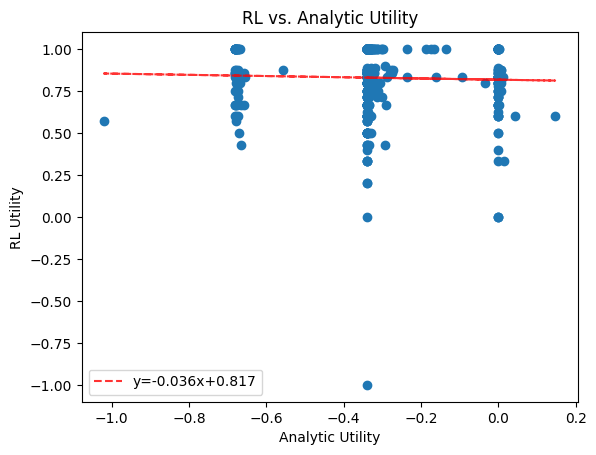

In [85]:
analytic_utility = [x[0] for x in analytic_rl_pairs]

rl_utility = [x[1] for x in analytic_rl_pairs]
# Add line of best fit
z = np.polyfit(analytic_utility, rl_utility, 1)
p = np.poly1d(z)
plt.plot(analytic_utility, p(analytic_utility), "r--", alpha=0.8, label=f"y={z[0]:.3f}x+{z[1]:.3f}")
plt.legend()

plt.scatter(analytic_utility, rl_utility)
plt.xlabel("Analytic Utility")
plt.ylabel("RL Utility")
plt.title("RL vs. Analytic Utility")
plt.show()

In [53]:
train_env.step(np.array([0]));

BrokenPipeError: [Errno 32] Broken pipe